# Processamento e Análise de Dados - Case Técnico ifood
---
Este notebook realiza o processamento, limpeza e análise dos dados do programa de recompensas e cupons do Ifood.

**Datasets:**
- `offers.json`: Metadados das ofertas promocionais
- `profile.json`: Perfil demográfico dos clientes
- `transactions.json`: Eventos de transações e interações com ofertas

## 1. Importação de Bibliotecas e Configurações Iniciais

In [0]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, count, when, struct, explode, size, desc, asc
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# configurações para visualização
plt.style.use('seaborn-v0_8')
sns.set_palette("Reds") 

## 2. Carregamento e Exploração Inicial dos Dados

In [0]:
df_offers = spark.read.json("/Volumes/workspace/default/data/offers.json")
df_profile = spark.read.json("/Volumes/workspace/default/data/profile.json")
df_transactions = spark.read.json("/Volumes/workspace/default/data/transactions.json")


print(f"Offers: {df_offers.count():,} linhas, {len(df_offers.columns)} colunas")
print(f"Profile: {df_profile.count():,} linhas, {len(df_profile.columns)} colunas")
print(f"Transactions: {df_transactions.count():,} linhas, {len(df_transactions.columns)} colunas")

Offers: 10 linhas, 6 colunas
Profile: 17,000 linhas, 5 colunas
Transactions: 306,534 linhas, 4 colunas


### 2.1 Análise do Dataset de Ofertas

In [0]:
df_offers.printSchema()
df_offers.describe().show()
df_offers.show()

root
 |-- channels: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- discount_value: long (nullable = true)
 |-- duration: double (nullable = true)
 |-- id: string (nullable = true)
 |-- min_value: long (nullable = true)
 |-- offer_type: string (nullable = true)

+-------+------------------+------------------+--------------------+------------------+-------------+
|summary|    discount_value|          duration|                  id|         min_value|   offer_type|
+-------+------------------+------------------+--------------------+------------------+-------------+
|  count|                10|                10|                  10|                10|           10|
|   mean|               4.2|               6.5|                NULL|               7.7|         NULL|
| stddev|3.5839146815241634|2.3213980461973533|                NULL|5.8319045869347965|         NULL|
|    min|                 0|               3.0|0b1e1539f2cc45b7b...|                 0|         

In [0]:
df_offers.groupBy("offer_type").count().orderBy("count", ascending=False).show()
df_channels_exploded = df_offers.select("offer_type", explode("channels").alias("channel"))
df_channels_exploded.groupBy("channel").count().orderBy("count", ascending=False).show()


+-------------+-----+
|   offer_type|count|
+-------------+-----+
|         bogo|    4|
|     discount|    4|
|informational|    2|
+-------------+-----+

+-------+-----+
|channel|count|
+-------+-----+
|  email|   10|
| mobile|    9|
|    web|    8|
| social|    6|
+-------+-----+



O `offers.json` é uma tabela simples com 10 linhas e não aparenta ter nenhuma anormalidade nos dados.

É interessante observar que, dos 4 canais de veiculação disponíveis, o email está presente em todas as ofertas (10/10), seguido de mobile (9/10), web(8/10) e social (6/10).

### 2.2 Análise do Dataset de Perfis

In [0]:
df_profile.printSchema()
df_profile.show()
df_profile.describe().show()

root
 |-- age: long (nullable = true)
 |-- credit_card_limit: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- id: string (nullable = true)
 |-- registered_on: string (nullable = true)

+---+-----------------+------+--------------------+-------------+
|age|credit_card_limit|gender|                  id|registered_on|
+---+-----------------+------+--------------------+-------------+
|118|             NULL|  NULL|68be06ca386d4c319...|     20170212|
| 55|         112000.0|     F|0610b486422d4921a...|     20170715|
|118|             NULL|  NULL|38fe809add3b4fcf9...|     20180712|
| 75|         100000.0|     F|78afa995795e4d85b...|     20170509|
|118|             NULL|  NULL|a03223e636434f42a...|     20170804|
| 68|          70000.0|     M|e2127556f4f64592b...|     20180426|
|118|             NULL|  NULL|8ec6ce2a7e7949b1b...|     20170925|
|118|             NULL|  NULL|68617ca6246f4fbc8...|     20171002|
| 65|          53000.0|     M|389bc3fa690240e79...|     20180209|
|11

Aqui, somente observando o describe e as 20 primeiras linhas da tablea, já é possível observar que existem alguns registros com a idade de 118 anos, limite do cartão de crédito Nulo e gênero também nulo. 

Vamos investigar mais a fundo sobre quantos destes registros possuem esta anomalia e se todo registro com age = 118 necessariamente possui limite do cartão e gênero nulos ou não. Essas informações serão pertinentes para a etapa da limpeza e tratamento dos dados desta tabela. 

In [0]:
# anomalia de idade = 118
age_118_count = df_profile.filter(col("age") == 118).count()
total_profiles = df_profile.count()
print(f"Registros com idade 118: {age_118_count:,} ({age_118_count/total_profiles*100:.1f}% do total)")

Registros com idade 118: 2,175 (12.8% do total)


In [0]:
age_118_analysis = (df_profile
    .filter(col("age") == 118)
    .select([
        count("*").alias("total_registros"),
        count(when(col("gender").isNull(), 1)).alias("gender_nulo"),
        count(when(col("credit_card_limit").isNull(), 1)).alias("limite_nulo"),
        count(when(col("registered_on").isNull(), 1)).alias("data_registro_nulo")
    ])
)
age_118_analysis.show()

+---------------+-----------+-----------+------------------+
|total_registros|gender_nulo|limite_nulo|data_registro_nulo|
+---------------+-----------+-----------+------------------+
|           2175|       2175|       2175|                 0|
+---------------+-----------+-----------+------------------+



In [0]:
# Distribuição de idades (top 20)
print("Top 20 Idades mais Comuns:")
df_profile.groupBy("age").count().orderBy("count", ascending=False).show(20)

Top 20 Idades mais Comuns:
+---+-----+
|age|count|
+---+-----+
|118| 2175|
| 58|  408|
| 53|  372|
| 51|  363|
| 59|  359|
| 54|  359|
| 57|  353|
| 52|  351|
| 55|  350|
| 56|  342|
| 63|  338|
| 60|  333|
| 49|  321|
| 62|  318|
| 67|  317|
| 64|  311|
| 61|  309|
| 48|  288|
| 50|  284|
| 66|  284|
+---+-----+
only showing top 20 rows


In [0]:
# analise dos valores nulos
null_analysis = df_profile.select([
    count(when(col(c).isNull(), c)).alias(f"{c}_nulos") for c in df_profile.columns
])
null_analysis.show()

+---------+-----------------------+------------+--------+-------------------+
|age_nulos|credit_card_limit_nulos|gender_nulos|id_nulos|registered_on_nulos|
+---------+-----------------------+------------+--------+-------------------+
|        0|                   2175|        2175|       0|                  0|
+---------+-----------------------+------------+--------+-------------------+



### 2.3 Análise do Dataset de Transações

In [0]:

df_transactions.printSchema()
df_transactions.show(truncate=False)
df_transactions.describe().show()


root
 |-- account_id: string (nullable = true)
 |-- event: string (nullable = true)
 |-- time_since_test_start: double (nullable = true)
 |-- value: struct (nullable = true)
 |    |-- amount: double (nullable = true)
 |    |-- offer id: string (nullable = true)
 |    |-- offer_id: string (nullable = true)
 |    |-- reward: double (nullable = true)

+--------------------------------+--------------+---------------------+----------------------------------------------------+
|account_id                      |event         |time_since_test_start|value                                               |
+--------------------------------+--------------+---------------------+----------------------------------------------------+
|78afa995795e4d85b5d9ceeca43f5fef|offer received|0.0                  |{NULL, 9b98b8c7a33c4b65b9aebfe6a799e6d9, NULL, NULL}|
|a03223e636434f42ac4c3df47e8bac43|offer received|0.0                  |{NULL, 0b1e1539f2cc45b7b9fa7c272da2e1d7, NULL, NULL}|
|e2127556f4f64592b11af22

In [0]:
display(df_transactions)

account_id event time_since_test_start value 78afa995795e4d85b5d9ceeca43f5fef offer received 0.0 List(null, 9b98b8c7a33c4b65b9aebfe6a799e6d9, null, null) a03223e636434f42ac4c3df47e8bac43 offer received 0.0 List(null, 0b1e1539f2cc45b7b9fa7c272da2e1d7, null, null) e2127556f4f64592b11af22de27a7932 offer received 0.0 List(null, 2906b810c7d4411798c6938adc9daaa5, null, null) 8ec6ce2a7e7949b1bf142def7d0e0586 offer received 0.0 List(null, fafdcd668e3743c1bb461111dcafc2a4, null, null) 68617ca6246f4fbc85e91a2a49552598 offer received 0.0 List(null, 4d5c57ea9a6940dd891ad53e9dbe8da0, null, null) 389bc3fa690240e798340f5a15918d5c offer received 0.0 List(null, f19421c1d4aa40978ebb69ca19b0e20d, null, null) c4863c7985cf408faee930f111475da3 offer received 0.0 List(null, 2298d6c36e964ae4a3e7e9706d1fb8c2, null, null) 2eeac8d8feae4a8cad5a6af0499a211d offer received 0.0 List(null, 3f207df678b143eea3cee63160fa8bed, null, null) aa4862eba776480b8bb9c68455b8c2e1 offer received 0.0 List(null, 0b1e1539f2cc45b7b9fa7c272da2e1d7, null, null) 31dda685af34476cad5bc968bdb01c53 offer received 0.0 List(null, 0b1e1539f2cc45b7b9fa7c272da2e1d7, null, null) 744d603ef08c4f33af5a61c8c7628d1c offer received 0.0 List(null, 0b1e1539f2cc45b7b9fa7c272da2e1d7, null, null) 3d02345581554e81b7b289ab5e288078 offer received 0.0 List(null, 0b1e1539f2cc45b7b9fa7c272da2e1d7, null, null) 4b0da7e80e5945209a1fdddfe813dbe0 offer received 0.0 List(null, ae264e3637204a6fb9bb56bc8210ddfd, null, null) c27e0d6ab72c455a8bb66d980963de60 offer received 0.0 List(null, 3f207df678b143eea3cee63160fa8bed, null, null) d53717f5400c4e84affdaeda9dd926b3 offer received 0.0 List(null, 0b1e1539f2cc45b7b9fa7c272da2e1d7, null, null) f806632c011441378d4646567f357a21 offer received 0.0 List(null, fafdcd668e3743c1bb461111dcafc2a4, null, null) d058f73bf8674a26a95227db098147b1 offer received 0.0 List(null, 0b1e1539f2cc45b7b9fa7c272da2e1d7, null, null) 65aba5c617294649aeb624da249e1ee5 offer received 0.0 List(null, 2906b810c7d4411798c6938adc9daaa5, null, null) ebe7ef46ea6f4963a7dd49f501b26779 offer received 0.0 List(null, 9b98b8c7a33c4b65b9aebfe6a799e6d9, null, null) 1e9420836d554513ab90eba98552d0a9 offer received 0.0 List(null, ae264e3637204a6fb9bb56bc8210ddfd, null, null) 868317b9be554cb18e50bc68484749a2 offer received 0.0 List(null, 2906b810c7d4411798c6938adc9daaa5, null, null) f082d80f0aac47a99173ba8ef8fc1909 offer received 0.0 List(null, 9b98b8c7a33c4b65b9aebfe6a799e6d9, null, null) 102e9454054946fda62242d2e176fdce offer received 0.0 List(null, 4d5c57ea9a6940dd891ad53e9dbe8da0, null, null) 4beeb3ed64dd4898b0edf2f6b67426d3 offer received 0.0 List(null, 2906b810c7d4411798c6938adc9daaa5, null, null) 9f30b375d7bd4c62a884ffe7034e09ee offer received 0.0 List(null, 2298d6c36e964ae4a3e7e9706d1fb8c2, null, null) 25c906289d154b66bf579693f89481c9 offer received 0.0 List(null, 2906b810c7d4411798c6938adc9daaa5, null, null) 6e014185620b49bd98749f728747572f offer received 0.0 List(null, f19421c1d4aa40978ebb69ca19b0e20d, null, null) 02c083884c7d45b39cc68e1314fec56c offer received 0.0 List(null, ae264e3637204a6fb9bb56bc8210ddfd, null, null) c0d210398dee4a0895b24444a5fcd1d2 offer received 0.0 List(null, 9b98b8c7a33c4b65b9aebfe6a799e6d9, null, null) 8be4463721e14d7fa600686bf8c8b2ed offer received 0.0 List(null, fafdcd668e3743c1bb461111dcafc2a4, null, null) 57dd18ec5ddc46828afb81ec5977bef2 offer received 0.0 List(null, 9b98b8c7a33c4b65b9aebfe6a799e6d9, null, null) be8a5d1981a2458d90b255ddc7e0d174 offer received 0.0 List(null, 5a8bc65990b245e5a138643cd4eb9837, null, null) a3b9b4bf115e4564933ea2e4bc936843 offer received 0.0 List(null, 9b98b8c7a33c4b65b9aebfe6a799e6d9, null, null) 7584948ea6d04f94b8798624706261c2 offer received 0.0 List(null, 4d5c57ea9a6940dd891ad53e9dbe8da0, null, null) 9c64321646bf40f6ad1bc98864eaa6b8 offer received 0.0 List(null, fafdcd668e3743c1bb461111dcafc2a4, null, null) 676506bad68e4161b9bbaffeb039626b offer received 0.0 List(null, ae264e3637204a6fb9bb56bc8210ddfd, null, null) 9fa9ae8f57894cc9a3b8a9bbe0fc1b2

Aqui, já conseguimos perceber uma inconsistência dentro do campo value. Existem registros com "offer_id" e "offer id", de forma que seguem o seguinte padrão:

- Se `event == offer received`,  "offer id" = notnull e "offer_id" =  null

- Se `event == offer viewed`, "offer id" =  notnull e  "offer_id" =  null

- Se `event == offer completed`, "offer id" =  null e "offer_id" = notnull

- Se `event == transaction`,  "offer id" = null e "offer_id" = null

Além disso, é possível observar que value.ammount só possui valor não nulo quando event == transaction e value.reward só tem quando event == offer completed

In [0]:
# análise do problema "offer_id" vs "offer id"
offer_id_check = df_transactions.select(
    count(when(col("value.offer_id").isNotNull(), 1)).alias("offer_id_nao_nulo"),
    count(when(col("value.`offer id`").isNotNull(), 1)).alias("offer_id_espaco_nao_nulo"),
    count("*").alias("total_registros")
)
offer_id_check.show()

+-----------------+------------------------+---------------+
|offer_id_nao_nulo|offer_id_espaco_nao_nulo|total_registros|
+-----------------+------------------------+---------------+
|            33579|                  134002|         306534|
+-----------------+------------------------+---------------+



In [0]:
# tipos de eventos
df_transactions.groupBy("event").count().orderBy("count",ascending=False).show()

+---------------+------+
|          event| count|
+---------------+------+
|    transaction|138953|
| offer received| 76277|
|   offer viewed| 57725|
|offer completed| 33579|
+---------------+------+



## 3. Limpeza e Correção dos Dados

### 3.1 Limpeza do Dataset de Ofertas

In [0]:
# verificando duplicatas
total_offers = df_offers.count()
unique_offers = df_offers.dropDuplicates().count()
duplicated_offers = total_offers - unique_offers

print(f"Ofertas duplicadas encontradas: {duplicated_offers}")

Ofertas duplicadas encontradas: 0


In [0]:
# verificando se todos os IDs são únicos
unique_ids = df_offers.select("id").distinct().count()
print(f"IDs únicos de ofertas: {unique_ids} (deve ser igual ao total: {total_offers})")

IDs únicos de ofertas: 10 (deve ser igual ao total: 10)


In [0]:
# valores negativos ou inválidos
invalid_offers = df_offers.filter(
    (col("duration") <= 0) | 
    (col("min_value") < 0) | 
    (col("discount_value") < 0)
).count()

print(f"Ofertas com valores inválidos: {invalid_offers}")

Ofertas com valores inválidos: 0


Por se tratar de uma tabela com apenas 10 linhas e como não encontrei nenhum valor inválido ou duplicado, não foi necessário realizar tratamento neste df.

### 3.2 Limpeza do Dataset de Perfis

In [0]:
# verificando se existem registros válidos com idade 118
age_118_valid = df_profile.filter(
    (col("age") == 118) & 
    (col("gender").isNotNull()) & 
    (col("credit_card_limit").isNotNull())
).count()

print(f"Registros com idade 118 e dados completos: {age_118_valid}")

Registros com idade 118 e dados completos: 0


In [0]:
# estratégia de limpeza: remover apenas registros com idade 118 e dados demográficos nulos (ou seja, todos os age == 118)
# isso preservaria possíveis clientes legítimos de 118 anos com dados completos, caso houvesse

df_profile_step1 = df_profile.filter(
    ~((col("age") == 118) & 
      (col("gender").isNull()) & 
      (col("credit_card_limit").isNull()))
)

In [0]:
# removendo registros com dados críticos nulos
df_profile_clean = df_profile_step1.dropna(subset=["age", "gender", "credit_card_limit", "id"])

In [0]:
# verificando idades válidas (clientes maiores de idade). Aqui, vou englobar também os clientes com idade até 104 anos = 5 clientes.
invalid_ages = df_profile_clean.filter(
    (col("age") < 18)
).count()

print(f"Perfis com idades inválidas (< 18): {invalid_ages}")

# verificando limites de cartão razoáveis (limites menores do que 0 e maiores que 1 milhão de reais)
invalid_limits = df_profile_clean.filter(
    (col("credit_card_limit") <= 0) | (col("credit_card_limit") > 200000)
).count()

print(f"Perfis com limites inválidos: {invalid_limits}")

# verificando duplicatas de ID
total_profiles_clean = df_profile_clean.count()
unique_profile_ids = df_profile_clean.select("id").distinct().count()

print(f"Perfis após limpeza: {total_profiles_clean:,}")
print(f"IDs únicos: {unique_profile_ids:,} (deve ser igual ao total)")

Perfis com idades inválidas (< 18): 0
Perfis com limites inválidos: 0
Perfis após limpeza: 14,825
IDs únicos: 14,825 (deve ser igual ao total)


In [0]:
df_profile_clean.describe().show()

+-------+------------------+-----------------+------+--------------------+--------------------+
|summary|               age|credit_card_limit|gender|                  id|       registered_on|
+-------+------------------+-----------------+------+--------------------+--------------------+
|  count|             14825|            14825| 14825|               14825|               14825|
|   mean| 54.39352445193929| 65404.9915682968|  NULL|2.565638242424101E31|2.0166887148532882E7|
| stddev|17.383705365854993|21598.29941022947|  NULL|                NULL|  11885.653317267022|
|    min|                18|          30000.0|     F|0009655768c64bdeb...|            20130729|
|    max|               101|         120000.0|     O|ffff82501cea40309...|            20180726|
+-------+------------------+-----------------+------+--------------------+--------------------+



### 3.3 Limpeza do Dataset de Transações

In [0]:
# corrigindo o problema do campo offer_id inconsistente
df_transactions_fixed = df_transactions.withColumn(
    "value",
    struct(
        col("value.amount").alias("amount"),
        # unificando offer_id: usar offer_id se não nulo, senão usar "offer id"
        when(col("value.offer_id").isNotNull(), col("value.offer_id"))
        .otherwise(col("value.`offer id`")).alias("offer_id"),
        col("value.reward").alias("reward")
    )
)

# verificando se a correção funcionou
fixed_check = df_transactions_fixed.select(
    count(when(col("value.offer_id").isNotNull(), 1)).alias("offer_id_nao_nulos"),
    count("*").alias("total_registros")
)
fixed_check.show()

+------------------+---------------+
|offer_id_nao_nulos|total_registros|
+------------------+---------------+
|            167581|         306534|
+------------------+---------------+



In [0]:
display(df_transactions_fixed)

account_id event time_since_test_start value 78afa995795e4d85b5d9ceeca43f5fef offer received 0.0 List(null, 9b98b8c7a33c4b65b9aebfe6a799e6d9, null) a03223e636434f42ac4c3df47e8bac43 offer received 0.0 List(null, 0b1e1539f2cc45b7b9fa7c272da2e1d7, null) e2127556f4f64592b11af22de27a7932 offer received 0.0 List(null, 2906b810c7d4411798c6938adc9daaa5, null) 8ec6ce2a7e7949b1bf142def7d0e0586 offer received 0.0 List(null, fafdcd668e3743c1bb461111dcafc2a4, null) 68617ca6246f4fbc85e91a2a49552598 offer received 0.0 List(null, 4d5c57ea9a6940dd891ad53e9dbe8da0, null) 389bc3fa690240e798340f5a15918d5c offer received 0.0 List(null, f19421c1d4aa40978ebb69ca19b0e20d, null) c4863c7985cf408faee930f111475da3 offer received 0.0 List(null, 2298d6c36e964ae4a3e7e9706d1fb8c2, null) 2eeac8d8feae4a8cad5a6af0499a211d offer received 0.0 List(null, 3f207df678b143eea3cee63160fa8bed, null) aa4862eba776480b8bb9c68455b8c2e1 offer received 0.0 List(null, 0b1e1539f2cc45b7b9fa7c272da2e1d7, null) 31dda685af34476cad5bc968bdb01c53 offer received 0.0 List(null, 0b1e1539f2cc45b7b9fa7c272da2e1d7, null) 744d603ef08c4f33af5a61c8c7628d1c offer received 0.0 List(null, 0b1e1539f2cc45b7b9fa7c272da2e1d7, null) 3d02345581554e81b7b289ab5e288078 offer received 0.0 List(null, 0b1e1539f2cc45b7b9fa7c272da2e1d7, null) 4b0da7e80e5945209a1fdddfe813dbe0 offer received 0.0 List(null, ae264e3637204a6fb9bb56bc8210ddfd, null) c27e0d6ab72c455a8bb66d980963de60 offer received 0.0 List(null, 3f207df678b143eea3cee63160fa8bed, null) d53717f5400c4e84affdaeda9dd926b3 offer received 0.0 List(null, 0b1e1539f2cc45b7b9fa7c272da2e1d7, null) f806632c011441378d4646567f357a21 offer received 0.0 List(null, fafdcd668e3743c1bb461111dcafc2a4, null) d058f73bf8674a26a95227db098147b1 offer received 0.0 List(null, 0b1e1539f2cc45b7b9fa7c272da2e1d7, null) 65aba5c617294649aeb624da249e1ee5 offer received 0.0 List(null, 2906b810c7d4411798c6938adc9daaa5, null) ebe7ef46ea6f4963a7dd49f501b26779 offer received 0.0 List(null, 9b98b8c7a33c4b65b9aebfe6a799e6d9, null) 1e9420836d554513ab90eba98552d0a9 offer received 0.0 List(null, ae264e3637204a6fb9bb56bc8210ddfd, null) 868317b9be554cb18e50bc68484749a2 offer received 0.0 List(null, 2906b810c7d4411798c6938adc9daaa5, null) f082d80f0aac47a99173ba8ef8fc1909 offer received 0.0 List(null, 9b98b8c7a33c4b65b9aebfe6a799e6d9, null) 102e9454054946fda62242d2e176fdce offer received 0.0 List(null, 4d5c57ea9a6940dd891ad53e9dbe8da0, null) 4beeb3ed64dd4898b0edf2f6b67426d3 offer received 0.0 List(null, 2906b810c7d4411798c6938adc9daaa5, null) 9f30b375d7bd4c62a884ffe7034e09ee offer received 0.0 List(null, 2298d6c36e964ae4a3e7e9706d1fb8c2, null) 25c906289d154b66bf579693f89481c9 offer received 0.0 List(null, 2906b810c7d4411798c6938adc9daaa5, null) 6e014185620b49bd98749f728747572f offer received 0.0 List(null, f19421c1d4aa40978ebb69ca19b0e20d, null) 02c083884c7d45b39cc68e1314fec56c offer received 0.0 List(null, ae264e3637204a6fb9bb56bc8210ddfd, null) c0d210398dee4a0895b24444a5fcd1d2 offer received 0.0 List(null, 9b98b8c7a33c4b65b9aebfe6a799e6d9, null) 8be4463721e14d7fa600686bf8c8b2ed offer received 0.0 List(null, fafdcd668e3743c1bb461111dcafc2a4, null) 57dd18ec5ddc46828afb81ec5977bef2 offer received 0.0 List(null, 9b98b8c7a33c4b65b9aebfe6a799e6d9, null) be8a5d1981a2458d90b255ddc7e0d174 offer received 0.0 List(null, 5a8bc65990b245e5a138643cd4eb9837, null) a3b9b4bf115e4564933ea2e4bc936843 offer received 0.0 List(null, 9b98b8c7a33c4b65b9aebfe6a799e6d9, null) 7584948ea6d04f94b8798624706261c2 offer received 0.0 List(null, 4d5c57ea9a6940dd891ad53e9dbe8da0, null) 9c64321646bf40f6ad1bc98864eaa6b8 offer received 0.0 List(null, fafdcd668e3743c1bb461111dcafc2a4, null) 676506bad68e4161b9bbaffeb039626b offer received 0.0 List(null, ae264e3637204a6fb9bb56bc8210ddfd, null) 9fa9ae8f57894cc9a3b8a9bbe0fc1b2f offer received 0.0 List(null, 2906b810c7d4411798c6938adc9daaa5, null) 020d3a52b9ce432ea5f98fc58e9bfcc4 offer received 0.0 List(null, 2906b810c7d4411798c6938adc9daaa5, null) 32fbf97e89274e8a935903f2ad095e1f offer re

In [0]:
# verificando duplicatas
total_transactions = df_transactions_fixed.count()
unique_transactions = df_transactions_fixed.dropDuplicates().count()
duplicated_transactions = total_transactions - unique_transactions
print(f"Transações duplicadas: {duplicated_transactions}")

Transações duplicadas: 397


In [0]:
# removendo as duplicatas
df_transactions_clean = df_transactions_fixed.dropDuplicates()
print(f"Transações após remoção de duplicatas: {df_transactions_clean.count():,}")

Transações após remoção de duplicatas: 306,137


In [0]:
# verificando valores de transação negativos
negative_amounts = df_transactions_clean.filter(col("value.amount") < 0).count()
print(f"Transações com valores negativos: {negative_amounts}")

# verificando se time_since_test_start é consistente
time_stats = df_transactions_clean.select("time_since_test_start").describe()
print("\nEstatísticas de tempo desde início do teste:")
time_stats.show()

print("\nDistribuição Final de Eventos:")
df_transactions_clean.groupBy("event").count().orderBy("count", ascending=False).show()

Transações com valores negativos: 0

Estatísticas de tempo desde início do teste:
+-------+---------------------+
|summary|time_since_test_start|
+-------+---------------------+
|  count|               306137|
|   mean|    15.25770896690044|
| stddev|    8.347840597971624|
|    min|                  0.0|
|    max|                29.75|
+-------+---------------------+


Distribuição Final de Eventos:
+---------------+------+
|          event| count|
+---------------+------+
|    transaction|138953|
| offer received| 76277|
|   offer viewed| 57725|
|offer completed| 33182|
+---------------+------+



## 4. Unificação dos Dados

In [0]:
# views temporárias para usar SQL
df_offers.createOrReplaceTempView("offers")
df_profile_clean.createOrReplaceTempView("profiles")
df_transactions_clean.createOrReplaceTempView("transactions")

In [0]:
# criando dataset unificado com melhorias na estrutura

df_unified = spark.sql("""
    SELECT
        -- Identificadores
        t.account_id as customer_id,
        
        -- Dados demográficos do cliente
        p.age as customer_age,
        p.gender as customer_gender,
        p.credit_card_limit,
        p.registered_on as registration_date,
        
        -- Dados do evento/transação
        t.event as event_type,
        t.time_since_test_start as days_since_start,
        
        -- Valores financeiros
        t.value.amount as transaction_amount,
        t.value.reward as reward_amount,
        
        -- Dados da oferta
        t.value.offer_id,
        o.offer_type,
        o.min_value as min_spend_required,
        o.duration as offer_duration_days,
        o.discount_value as offer_discount_value,
        o.channels as offer_channels,
        
        -- Campos derivados para análise
        CASE 
            WHEN t.event = 'transaction' THEN 'compra'
            WHEN t.event = 'offer received' THEN 'oferta_recebida'
            WHEN t.event = 'offer viewed' THEN 'oferta_visualizada'  
            WHEN t.event = 'offer completed' THEN 'oferta_completada'
            ELSE 'outro'
        END as event_category_pt,
        
        CASE 
            WHEN o.offer_type = 'bogo' THEN 'compre_leve'
            WHEN o.offer_type = 'discount' THEN 'desconto'
            WHEN o.offer_type = 'informational' THEN 'informativo'
            ELSE o.offer_type
        END as offer_type_pt,
        
        -- Segmentação por idade
        CASE 
            WHEN p.age < 25 THEN 'jovem'
            WHEN p.age BETWEEN 25 AND 34 THEN 'jovem_adulto'
            WHEN p.age BETWEEN 35 AND 49 THEN 'adulto'
            WHEN p.age BETWEEN 50 AND 64 THEN 'maduro'
            WHEN p.age >= 65 THEN 'idoso'
            ELSE 'indefinido'
        END as age_segment,
        
        -- Segmentação por limite de cartão
        CASE 
            WHEN p.credit_card_limit < 50000 THEN 'baixo'
            WHEN p.credit_card_limit BETWEEN 50000 AND 80000 THEN 'medio'
            WHEN p.credit_card_limit > 80000 THEN 'alto'
            ELSE 'indefinido'
        END as credit_segment
        
    FROM transactions t
    INNER JOIN profiles p ON t.account_id = p.id
    LEFT JOIN offers o ON t.value.offer_id = o.id
""")

# Estatísticas do dataset unificado
unified_count = df_unified.count()
unique_customers = df_unified.select("customer_id").distinct().count()

print(f"Total de registros: {unified_count:,}")
print(f"Clientes únicos: {unique_customers:,}")
print(f"Período: {df_unified.agg({'days_since_start': 'min'}).collect()[0][0]:.0f} a {df_unified.agg({'days_since_start': 'max'}).collect()[0][0]:.0f} dias")

Total de registros: 272,388
Clientes únicos: 14,825
Período: 0 a 30 dias


## 5. Relatório de Qualidade dos Dados

In [0]:
# campos críticos não podem ser nulos
critical_nulls = df_unified.select([
    count(when(col("customer_id").isNull(), 1)).alias("customer_id_nulo"),
    count(when(col("customer_age").isNull(), 1)).alias("idade_nula"),
    count(when(col("event_type").isNull(), 1)).alias("evento_nulo"),
    count(when(col("days_since_start").isNull(), 1)).alias("tempo_nulo")
])

print("Valores nulos em campos críticos:")
critical_nulls.show()

# distribuição de eventos
print("\nDistribuição Final de Eventos:")
event_distribution = df_unified.groupBy("event_category_pt", "event_type").count().orderBy("count", ascending=False)
event_distribution.show()

# distribuição por segmento etário
print("\nDistribuição por Segmento Etário:")
df_unified.groupBy("age_segment").count().orderBy("count", ascending=False).show()

# distribuição por gênero
print("\nDistribuição por Gênero:")
df_unified.groupBy("customer_gender").count().orderBy("count", ascending=False).show()

# cobertura de ofertas
print("\nAnálise de Cobertura de Ofertas:")
total_events = df_unified.count()
events_with_offers = df_unified.filter(col("offer_id").isNotNull()).count()
print(f"Eventos totais: {total_events:,}")
print(f"Eventos com oferta associada: {events_with_offers:,} ({events_with_offers/total_events*100:.1f}%)")

Valores nulos em campos críticos:
+----------------+----------+-----------+----------+
|customer_id_nulo|idade_nula|evento_nulo|tempo_nulo|
+----------------+----------+-----------+----------+
|               0|         0|          0|         0|
+----------------+----------+-----------+----------+


Distribuição Final de Eventos:
+------------------+---------------+------+
| event_category_pt|     event_type| count|
+------------------+---------------+------+
|            compra|    transaction|123957|
|   oferta_recebida| offer received| 66501|
|oferta_visualizada|   offer viewed| 49860|
| oferta_completada|offer completed| 32070|
+------------------+---------------+------+


Distribuição por Segmento Etário:
+------------+-----+
| age_segment|count|
+------------+-----+
|      maduro|92540|
|       idoso|76324|
|      adulto|59262|
|jovem_adulto|27229|
|       jovem|17033|
+------------+-----+


Distribuição por Gênero:
+---------------+------+
|customer_gender| count|
+-------------

## 6. Salvamento dos Dados Processados

In [0]:
# salvar como tabela Delta para uso futuro
df_unified.write.format("delta").mode("overwrite").saveAsTable("default.unified_data")


## 7. Análise Exploratória e Visualizações

In [0]:

# verificar tamanho para decidir se usar amostra
total_records = df_unified.count()

if total_records > 100000:
    sample_fraction = 0.25
    pdf_sample = df_unified.sample(sample_fraction, seed=42).toPandas()
    print(f"Usando amostra de {sample_fraction*100}% ({len(pdf_sample):,} registros) para visualizações")
else:
    pdf_sample = df_unified.toPandas()
    print(f"Usando dataset completo ({len(pdf_sample):,} registros) para visualizações")

Usando amostra de 25.0% (68,145 registros) para visualizações


### 7.1 Análise Demográfica

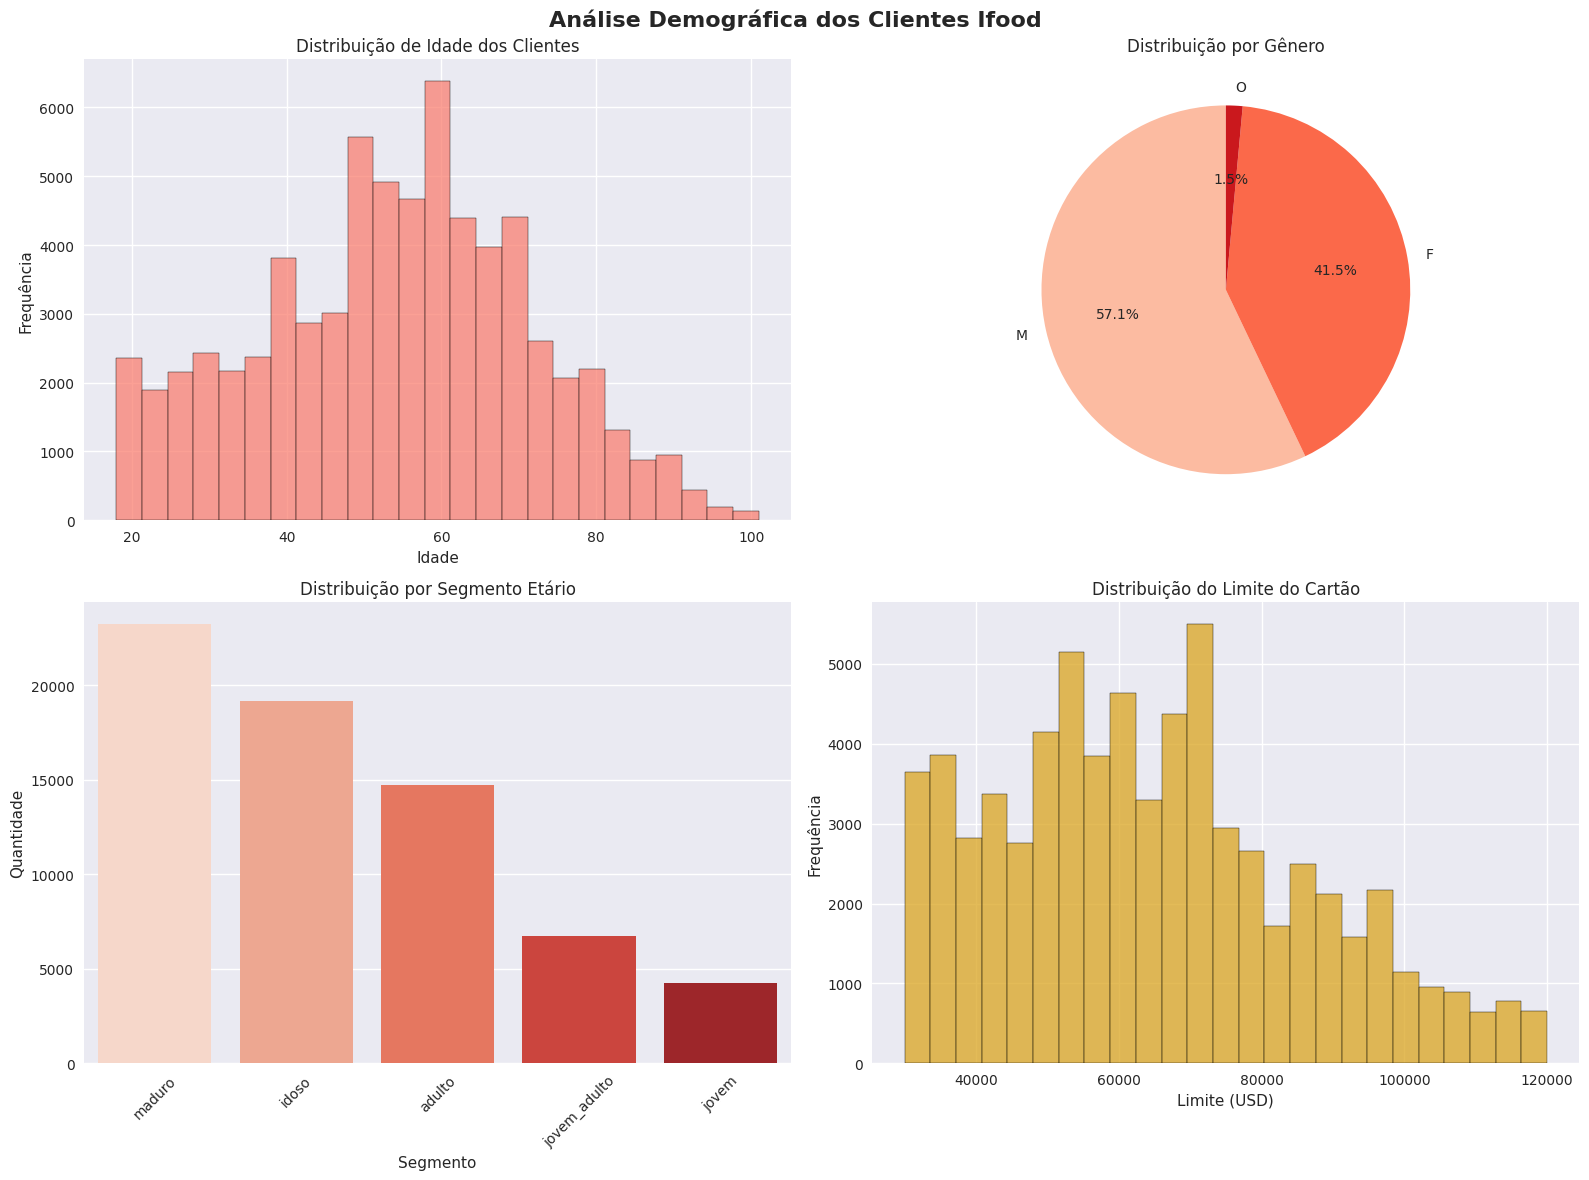

INSIGHTS DEMOGRÁFICOS:
• Idade média dos clientes: 53.9 anos
• Limite médio do cartão: $64,402
• Faixa etária predominante: maduro
• Distribuição de gênero: {'M': 38903, 'F': 28249, 'O': 993}


In [0]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Análise Demográfica dos Clientes Ifood', fontsize=16, fontweight='bold')

# 1. Distribuição de Idade
sns.histplot(pdf_sample['customer_age'].dropna(), bins=25, kde=False, ax=axes[0,0], color='salmon', edgecolor='black')
axes[0,0].set_title('Distribuição de Idade dos Clientes')
axes[0,0].set_xlabel('Idade')
axes[0,0].set_ylabel('Frequência')

# 2. Distribuição por Gênero
gender_counts = pdf_sample['customer_gender'].value_counts()
axes[0,1].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%', startangle=90,
              colors=sns.color_palette("Reds", len(gender_counts)))
axes[0,1].set_title('Distribuição por Gênero')

# 3. Segmentos Etários
age_segment_counts = pdf_sample['age_segment'].value_counts()
sns.barplot(x=age_segment_counts.index, y=age_segment_counts.values, ax=axes[1,0], palette="Reds")
axes[1,0].set_title('Distribuição por Segmento Etário')
axes[1,0].set_xlabel('Segmento')
axes[1,0].set_ylabel('Quantidade')
axes[1,0].tick_params(axis='x', rotation=45)

# 4. Limite do Cartão de Crédito
sns.histplot(pdf_sample['credit_card_limit'].dropna(), bins=25, kde=False, ax=axes[1,1], color='goldenrod', edgecolor='black')
axes[1,1].set_title('Distribuição do Limite do Cartão')
axes[1,1].set_xlabel('Limite (USD)')
axes[1,1].set_ylabel('Frequência')

plt.tight_layout()
plt.show()

# Insights demográficos
print("INSIGHTS DEMOGRÁFICOS:")
print(f"• Idade média dos clientes: {pdf_sample['customer_age'].mean():.1f} anos")
print(f"• Limite médio do cartão: ${pdf_sample['credit_card_limit'].mean():,.0f}")
print(f"• Faixa etária predominante: {pdf_sample['age_segment'].mode().iloc[0]}")
print(f"• Distribuição de gênero: {dict(pdf_sample['customer_gender'].value_counts())}")

### 7.2 Análise Comportamental

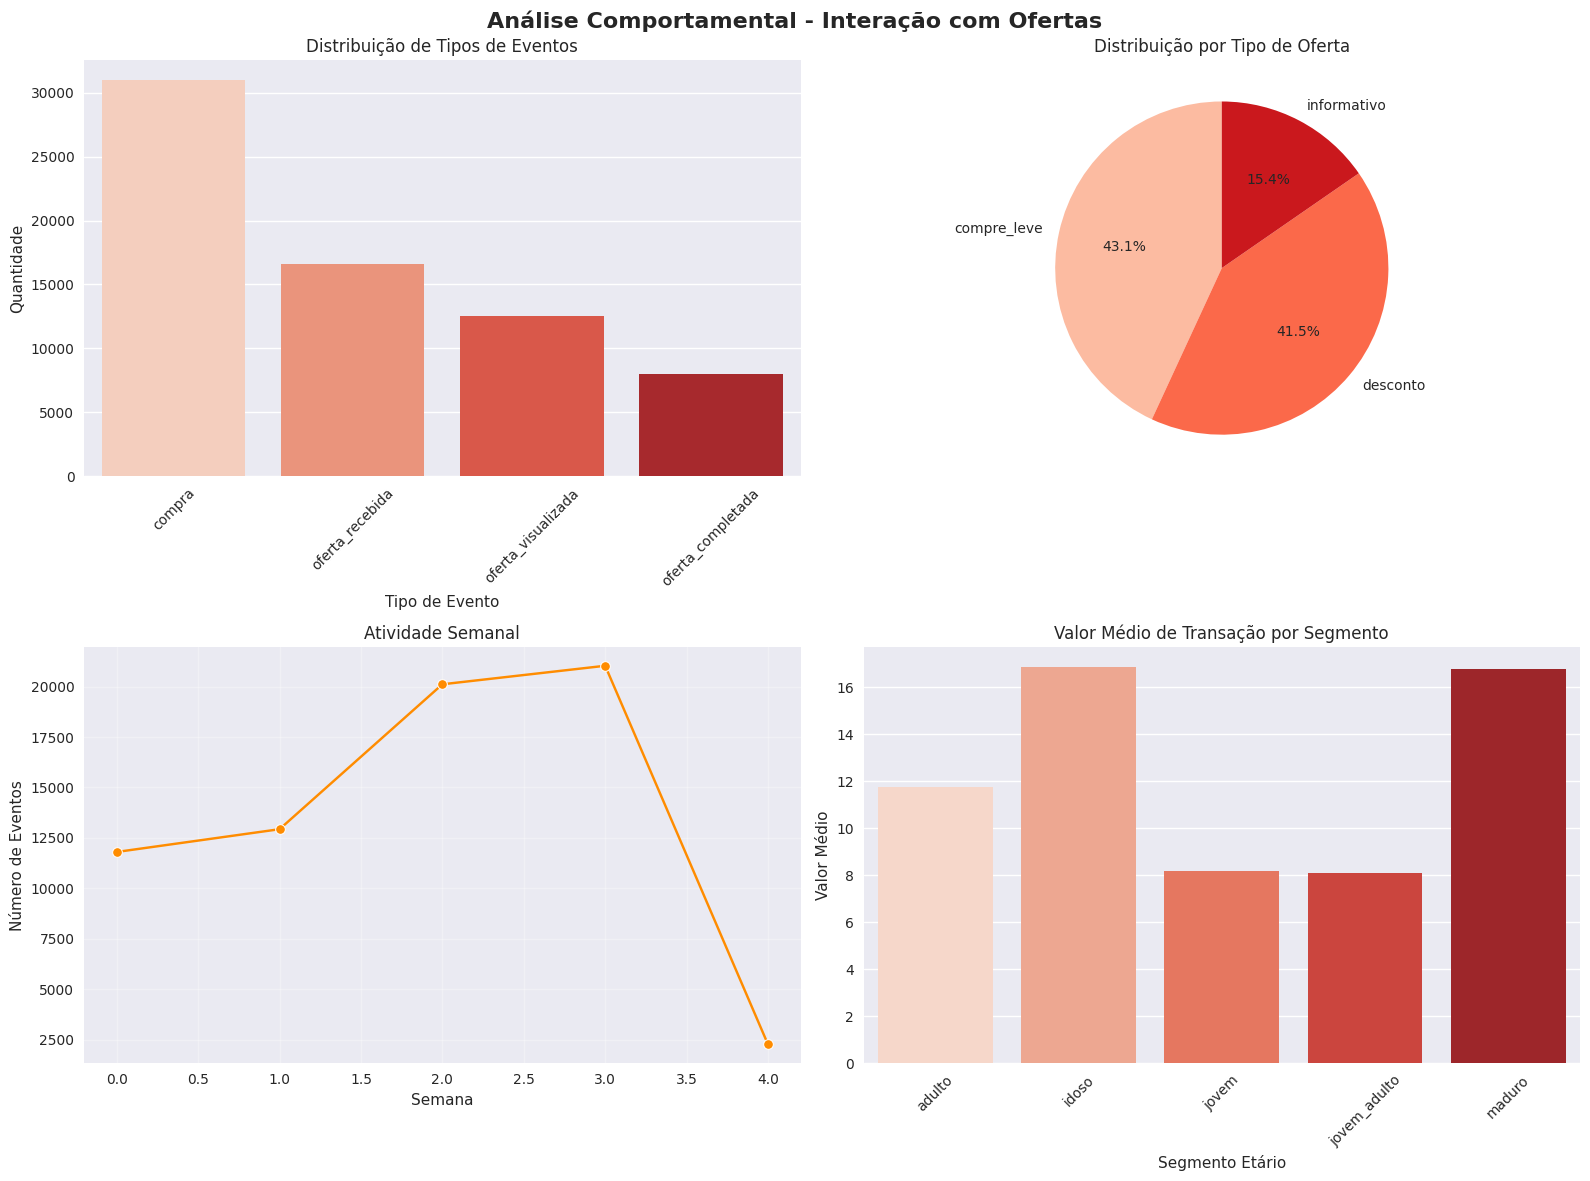

INSIGHTS COMPORTAMENTAIS:
Evento mais comum: compra
Tipo de oferta mais comum: compre_leve
Taxa de conversão de ofertas: 48.0%


In [0]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Análise Comportamental - Interação com Ofertas', fontsize=16, fontweight='bold')

# 1. Distribuição de Eventos
event_counts = pdf_sample['event_category_pt'].value_counts()
sns.barplot(x=event_counts.index, y=event_counts.values, ax=axes[0,0], palette="Reds")
axes[0,0].set_title('Distribuição de Tipos de Eventos')
axes[0,0].set_xlabel('Tipo de Evento')
axes[0,0].set_ylabel('Quantidade')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Tipos de Ofertas
offer_counts = pdf_sample['offer_type_pt'].value_counts().dropna()
axes[0,1].pie(
    offer_counts.values, 
    labels=offer_counts.index, 
    autopct='%1.1f%%', 
    startangle=90,
    colors=sns.color_palette("Reds", len(offer_counts))
)
axes[0,1].set_title('Distribuição por Tipo de Oferta')

# 3. Atividade ao Longo do Tempo (por semana)
pdf_sample['week'] = pdf_sample['days_since_start'] // 7
weekly_activity = pdf_sample.groupby('week').size().reset_index(name='count')
sns.lineplot(x='week', y='count', data=weekly_activity, ax=axes[1,0], marker='o', color='darkorange')
axes[1,0].set_title('Atividade Semanal')
axes[1,0].set_xlabel('Semana')
axes[1,0].set_ylabel('Número de Eventos')
axes[1,0].grid(True, alpha=0.3)

# 4. Valor Médio de Transação por Segmento
transaction_data = pdf_sample[pdf_sample['transaction_amount'].notna()]
if len(transaction_data) > 0:
    avg_transaction = transaction_data.groupby('age_segment')['transaction_amount'].mean().reset_index()
    sns.barplot(x='age_segment', y='transaction_amount', data=avg_transaction, ax=axes[1,1], palette="Reds")
    axes[1,1].set_title('Valor Médio de Transação por Segmento')
    axes[1,1].set_xlabel('Segmento Etário')
    axes[1,1].set_ylabel('Valor Médio')
    axes[1,1].tick_params(axis='x', rotation=45)
else:
    axes[1,1].text(
        0.5, 0.5, 'Dados de transação não disponíveis na amostra', 
        ha='center', va='center', transform=axes[1,1].transAxes
    )

plt.tight_layout()
plt.show()

# Insights 
print("INSIGHTS COMPORTAMENTAIS:")
print(f"Evento mais comum: {pdf_sample['event_category_pt'].mode().iloc[0]}")
if 'offer_type_pt' in pdf_sample.columns:
    most_common_offer = pdf_sample['offer_type_pt'].mode()
    if len(most_common_offer) > 0:
        print(f"Tipo de oferta mais comum: {most_common_offer.iloc[0]}")

# Calcular taxa de conversão
offers_received = len(pdf_sample[pdf_sample['event_category_pt'] == 'oferta_recebida'])
offers_completed = len(pdf_sample[pdf_sample['event_category_pt'] == 'oferta_completada'])
if offers_received > 0:
    conversion_rate = (offers_completed / offers_received) * 100
    print(f"Taxa de conversão de ofertas: {conversion_rate:.1f}%")

### 7.3 Análise de Performance de Ofertas

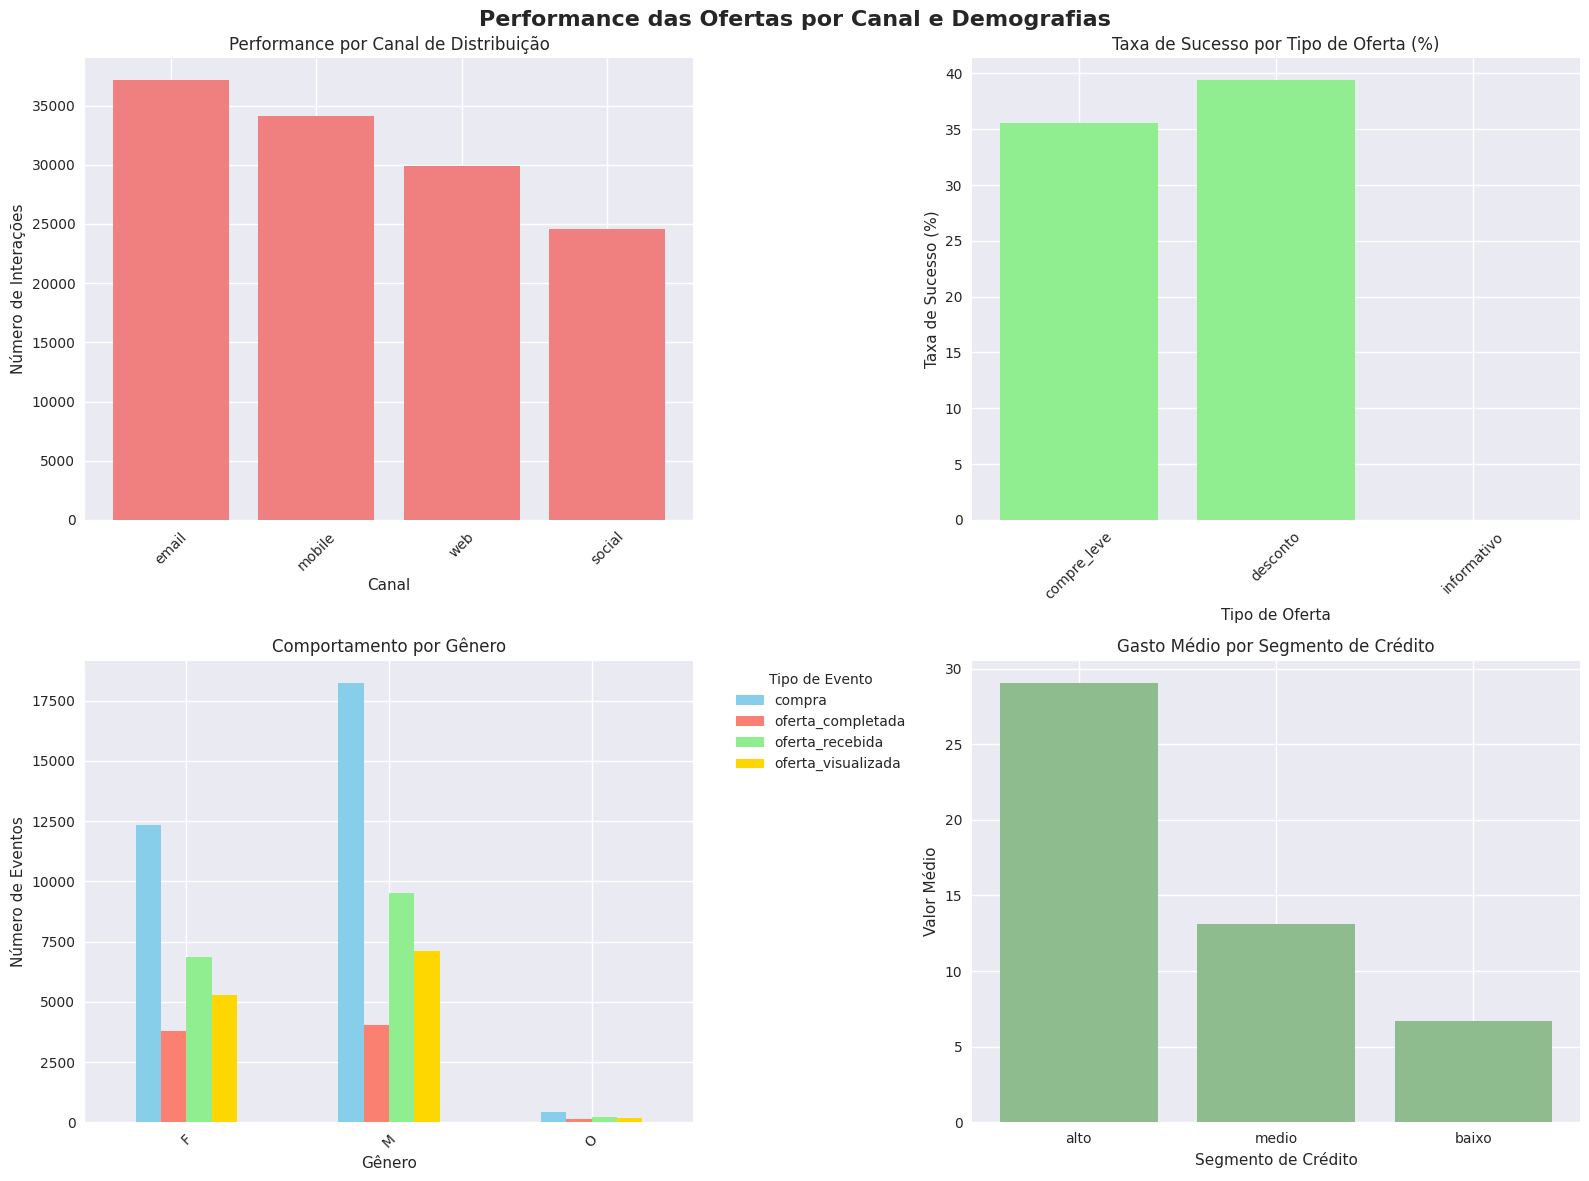

In [0]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Performance das Ofertas por Canal e Demografias', fontsize=16, fontweight='bold')

# 1. Performance por Canal (explodir canais primeiro)
if 'offer_channels' in pdf_sample.columns:
    channels_data = []

    for idx, row in pdf_sample.iterrows():
        channels = row['offer_channels']
        if isinstance(channels, (list, np.ndarray)) and len(channels) > 0:
            for channel in channels:
                channels_data.append({
                    'channel': channel,
                    'event_type': row['event_category_pt'],
                    'offer_type': row['offer_type_pt']
                })
    
    if channels_data:
        channels_df = pd.DataFrame(channels_data)
        channel_counts = channels_df['channel'].value_counts()
        axes[0,0].bar(channel_counts.index, channel_counts.values, color='lightcoral')
        axes[0,0].set_title('Performance por Canal de Distribuição')
        axes[0,0].set_xlabel('Canal')
        axes[0,0].set_ylabel('Número de Interações')
        axes[0,0].tick_params(axis='x', rotation=45)
    else:
        axes[0,0].text(0.5, 0.5, 'Dados de canais não disponíveis', 
                       ha='center', va='center', transform=axes[0,0].transAxes)

# 2. Taxa de Sucesso por Tipo de Oferta
offer_performance = pdf_sample.groupby(['offer_type_pt', 'event_category_pt']).size().unstack(fill_value=0)
if not offer_performance.empty and 'oferta_completada' in offer_performance.columns and 'oferta_recebida' in offer_performance.columns:
    success_rate = (offer_performance['oferta_completada'] / 
                   (offer_performance['oferta_recebida'] + offer_performance['oferta_completada']) * 100).fillna(0)
    axes[0,1].bar(success_rate.index, success_rate.values, color='lightgreen')
    axes[0,1].set_title('Taxa de Sucesso por Tipo de Oferta (%)')
    axes[0,1].set_xlabel('Tipo de Oferta')
    axes[0,1].set_ylabel('Taxa de Sucesso (%)')
    axes[0,1].tick_params(axis='x', rotation=45)
else:
    axes[0,1].text(0.5, 0.5, 'Dados insuficientes para calcular taxa de sucesso', 
                   ha='center', va='center', transform=axes[0,1].transAxes)

# 3. Comportamento por Gênero
gender_behavior = pdf_sample.groupby(['customer_gender', 'event_category_pt']).size().unstack(fill_value=0)
if not gender_behavior.empty:
    gender_behavior.plot(kind='bar', ax=axes[1,0], color=['skyblue', 'salmon', 'lightgreen', 'gold'])
    axes[1,0].set_title('Comportamento por Gênero')
    axes[1,0].set_xlabel('Gênero')
    axes[1,0].set_ylabel('Número de Eventos')
    axes[1,0].legend(title='Tipo de Evento', bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1,0].tick_params(axis='x', rotation=45)

# 4. Valor Médio de Compras por Segmento de Crédito
credit_spending = pdf_sample[pdf_sample['transaction_amount'].notna()]
if len(credit_spending) > 0:
    avg_spending = credit_spending.groupby('credit_segment')['transaction_amount'].mean().sort_values(ascending=False)
    axes[1,1].bar(avg_spending.index, avg_spending.values, color='darkseagreen')
    axes[1,1].set_title('Gasto Médio por Segmento de Crédito')
    axes[1,1].set_xlabel('Segmento de Crédito')
    axes[1,1].set_ylabel('Valor Médio')
else:
    axes[1,1].text(0.5, 0.5, 'Dados de transação não disponíveis', 
                   ha='center', va='center', transform=axes[1,1].transAxes)

plt.tight_layout()
plt.show()

### 7.4 Análise de Engajamento e Funil de Conversão

Distribuição de eventos:
compra: 31,010 eventos (45.5%)
oferta_recebida: 16,596 eventos (24.4%)
oferta_visualizada: 12,567 eventos (18.4%)
oferta_completada: 7,972 eventos (11.7%)

Métricas por cliente:
Total de clientes únicos: 14,528
Média de tipos de eventos por cliente: 2.58
Período médio de atividade: 17.3 dias


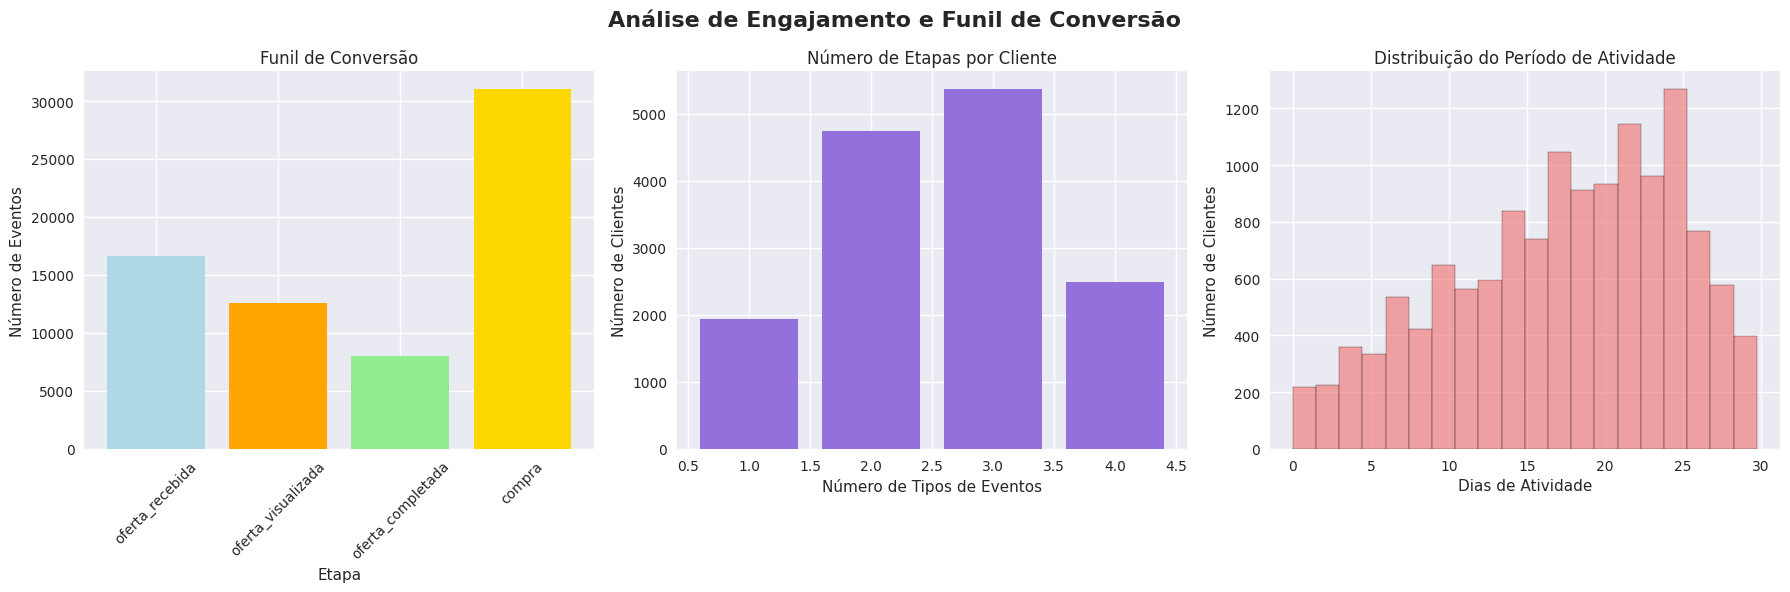

In [0]:
# métricas do funil
funnel_metrics = {}
total_customers = pdf_sample['customer_id'].nunique()
events_summary = pdf_sample['event_category_pt'].value_counts()
print("Distribuição de eventos:")
for event, count in events_summary.items():
    percentage = (count / len(pdf_sample)) * 100
    print(f"{event}: {count:,} eventos ({percentage:.1f}%)")

# análise por cliente - quantos clientes passaram por cada etapa
customer_funnel = pdf_sample.groupby('customer_id')['event_category_pt'].apply(lambda x: x.unique()).reset_index()
customer_funnel['num_stages'] = customer_funnel['event_category_pt'].apply(len)

print(f"\nMétricas por cliente:")
print(f"Total de clientes únicos: {total_customers:,}")
print(f"Média de tipos de eventos por cliente: {customer_funnel['num_stages'].mean():.2f}")

# tentando verificar se a visualização nos dá algum dado pertinente
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Análise de Engajamento e Funil de Conversão', fontsize=16, fontweight='bold')

# 1. Funil de conversão
funnel_data = events_summary.reindex(['oferta_recebida', 'oferta_visualizada', 'oferta_completada', 'compra'], fill_value=0)
colors_funnel = ['lightblue', 'orange', 'lightgreen', 'gold']
axes[0].bar(range(len(funnel_data)), funnel_data.values, color=colors_funnel[:len(funnel_data)])
axes[0].set_title('Funil de Conversão')
axes[0].set_xlabel('Etapa')
axes[0].set_ylabel('Número de Eventos')
axes[0].set_xticks(range(len(funnel_data)))
axes[0].set_xticklabels(funnel_data.index, rotation=45)

# 2. Distribuição de etapas por cliente
stage_distribution = customer_funnel['num_stages'].value_counts().sort_index()
axes[1].bar(stage_distribution.index, stage_distribution.values, color='mediumpurple')
axes[1].set_title('Número de Etapas por Cliente')
axes[1].set_xlabel('Número de Tipos de Eventos')
axes[1].set_ylabel('Número de Clientes')

# 3. Tempo médio entre eventos (se aplicável)
time_analysis = pdf_sample.groupby('customer_id')['days_since_start'].agg(['min', 'max', 'count']).reset_index()
time_analysis['time_span'] = time_analysis['max'] - time_analysis['min']
time_analysis = time_analysis[time_analysis['count'] > 1]  # Apenas clientes com múltiplos eventos

if len(time_analysis) > 0:
    axes[2].hist(time_analysis['time_span'], bins=20, color='lightcoral', edgecolor='black', alpha=0.7)
    axes[2].set_title('Distribuição do Período de Atividade')
    axes[2].set_xlabel('Dias de Atividade')
    axes[2].set_ylabel('Número de Clientes')
    print(f"Período médio de atividade: {time_analysis['time_span'].mean():.1f} dias")
else:
    axes[2].text(0.5, 0.5, 'Dados insuficientes para análise temporal', 
                 ha='center', va='center', transform=axes[2].transAxes)

plt.tight_layout()
plt.show()

### 7.5 Segmentação Avançada de Clientes

Aqui, acho interessante criar clusters de clientes baseados no comportamento. Segmentar clientes permite entender diferentes perfis de comportamento e valor, possibilitando ações personalizadas e mais eficazes.  

Isso pode nos ajudar a ter melhores insights e até na etapa da utilização dos modelos de ML.

No código, os clientes foram segmentados com base em **atividade (`total_events`)** e **gasto (`total_spent`)**, gerando quatro grupos:  
- **Alto Valor**: muitos eventos e alto gasto  
- **Médio Valor**: eventos e gasto moderados  
- **Engajado**: eventos frequentes, gasto baixo  
- **Baixo Engajamento**: poucos eventos e baixo gasto


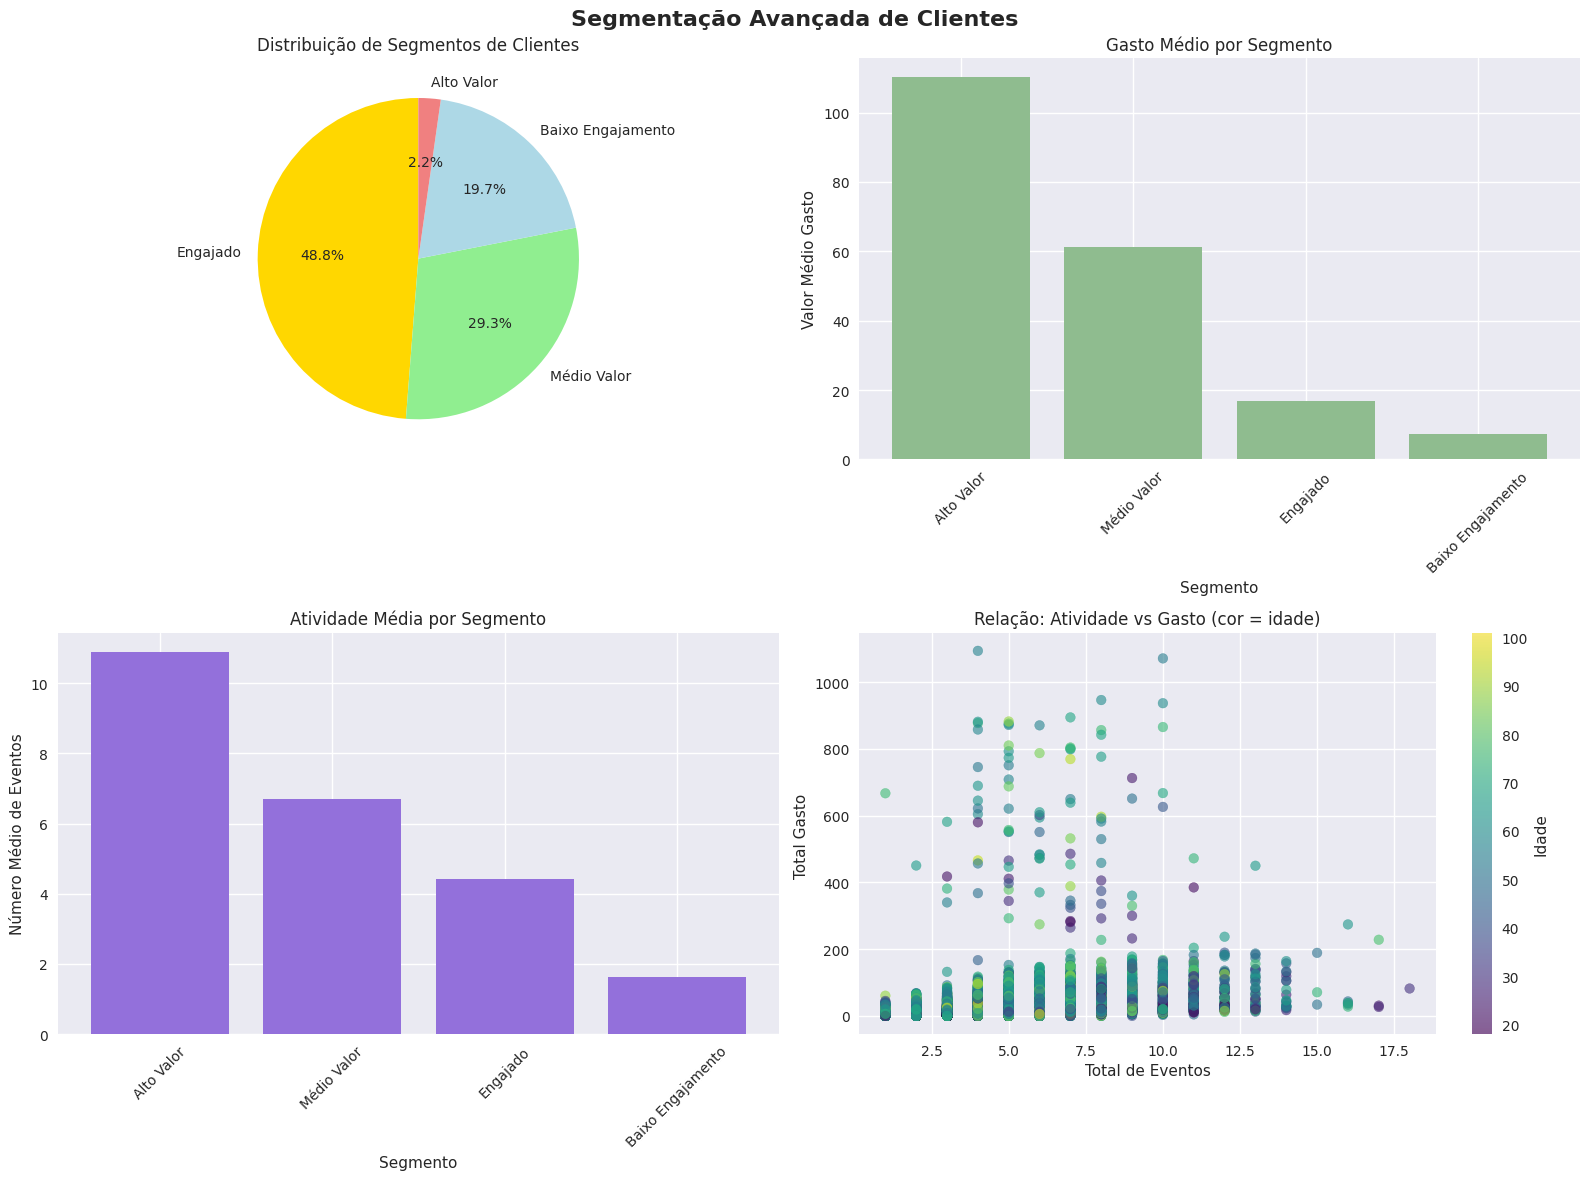

INSIGHTS DA SEGMENTAÇÃO:

 Engajado:
  - Quantidade: 7,085 clientes (48.8%)
  - Idade média: 53.1 anos
  - Gasto médio: $16.77
  - Atividade média: 4.4 eventos
  - Distribuição de gênero: {'M': 4394, 'F': 2593, 'O': 98}

 Médio Valor:
  - Quantidade: 4,260 clientes (29.3%)
  - Idade média: 56.1 anos
  - Gasto médio: $61.10
  - Atividade média: 6.7 eventos
  - Distribuição de gênero: {'F': 2119, 'M': 2071, 'O': 70}

 Baixo Engajamento:
  - Quantidade: 2,858 clientes (19.7%)
  - Idade média: 55.1 anos
  - Gasto médio: $7.40
  - Atividade média: 1.6 eventos
  - Distribuição de gênero: {'M': 1689, 'F': 1134, 'O': 35}

 Alto Valor:
  - Quantidade: 325 clientes (2.2%)
  - Idade média: 51.9 anos
  - Gasto médio: $110.25
  - Atividade média: 10.9 eventos
  - Distribuição de gênero: {'F': 163, 'M': 158, 'O': 4}


In [0]:
customer_profiles = pdf_sample.groupby('customer_id').agg({
    'event_category_pt': 'count',  # frequência de atividade
    'transaction_amount': 'sum',   # valor total gasto
    'customer_age': 'first',       # idade
    'customer_gender': 'first',    # gênero
    'credit_card_limit': 'first',  # Limite
    'days_since_start': 'max'      # ultimo dia de atividade
}).reset_index()

customer_profiles.columns = ['customer_id', 'total_events', 'total_spent', 'age', 'gender', 'credit_limit', 'last_activity']
customer_profiles['total_spent'] = customer_profiles['total_spent'].fillna(0)

def classify_customer(row):
    if row['total_events'] >= 10 and row['total_spent'] > 50:
        return 'Alto Valor'
    elif row['total_events'] >= 5 and row['total_spent'] > 20:
        return 'Médio Valor'
    elif row['total_events'] >= 3:
        return 'Engajado'
    else:
        return 'Baixo Engajamento'

customer_profiles['customer_segment'] = customer_profiles.apply(classify_customer, axis=1)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Segmentação Avançada de Clientes', fontsize=16, fontweight='bold')

# 1. Distribuição de segmentos
segment_counts = customer_profiles['customer_segment'].value_counts()
axes[0,0].pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%', 
              colors=['gold', 'lightgreen', 'lightblue', 'lightcoral'], startangle=90)
axes[0,0].set_title('Distribuição de Segmentos de Clientes')

# 2. Valor gasto por segmento
spending_by_segment = customer_profiles.groupby('customer_segment')['total_spent'].mean().sort_values(ascending=False)
axes[0,1].bar(spending_by_segment.index, spending_by_segment.values, color='darkseagreen')
axes[0,1].set_title('Gasto Médio por Segmento')
axes[0,1].set_xlabel('Segmento')
axes[0,1].set_ylabel('Valor Médio Gasto')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Atividade por segmento
activity_by_segment = customer_profiles.groupby('customer_segment')['total_events'].mean().sort_values(ascending=False)
axes[1,0].bar(activity_by_segment.index, activity_by_segment.values, color='mediumpurple')
axes[1,0].set_title('Atividade Média por Segmento')
axes[1,0].set_xlabel('Segmento')
axes[1,0].set_ylabel('Número Médio de Eventos')
axes[1,0].tick_params(axis='x', rotation=45)

# 4. Scatter plot: Atividade vs Gasto
scatter = axes[1,1].scatter(customer_profiles['total_events'], customer_profiles['total_spent'], 
                           c=customer_profiles['age'], cmap='viridis', alpha=0.6)
axes[1,1].set_title('Relação: Atividade vs Gasto (cor = idade)')
axes[1,1].set_xlabel('Total de Eventos')
axes[1,1].set_ylabel('Total Gasto ')
plt.colorbar(scatter, ax=axes[1,1], label='Idade')

plt.tight_layout()
plt.show()

# Insights da segmentação
print("INSIGHTS DA SEGMENTAÇÃO:")
for segment in segment_counts.index:
    segment_data = customer_profiles[customer_profiles['customer_segment'] == segment]
    print(f"\n {segment}:")
    print(f"  - Quantidade: {len(segment_data):,} clientes ({len(segment_data)/len(customer_profiles)*100:.1f}%)")
    print(f"  - Idade média: {segment_data['age'].mean():.1f} anos")
    print(f"  - Gasto médio: ${segment_data['total_spent'].mean():.2f}")
    print(f"  - Atividade média: {segment_data['total_events'].mean():.1f} eventos")
    if len(segment_data) > 0:
        gender_dist = segment_data['gender'].value_counts()
        print(f"  - Distribuição de gênero: {dict(gender_dist)}")

### 7.6 Insights de Negócio e Recomendações

In [0]:
# taxa de abertura de ofertas
offers_received = len(pdf_sample[pdf_sample['event_category_pt'] == 'oferta_recebida'])
offers_viewed = len(pdf_sample[pdf_sample['event_category_pt'] == 'oferta_visualizada'])
offers_completed = len(pdf_sample[pdf_sample['event_category_pt'] == 'oferta_completada'])

if offers_received > 0:
    view_rate = (offers_viewed / offers_received) * 100
    completion_rate = (offers_completed / offers_received) * 100
    print(f"Taxa de visualização: {view_rate:.1f}%")
    print(f"Taxa de conclusão: {completion_rate:.1f}%")

# Análise por tipo de oferta
if 'offer_type_pt' in pdf_sample.columns:
    offer_performance = pdf_sample.groupby('offer_type_pt')['event_category_pt'].apply(
        lambda x: (x == 'oferta_completada').sum() / len(x) * 100
    ).sort_values(ascending=False)
    
    print("\nPERFORMANCE POR TIPO DE OFERTA:")
    for offer_type, performance in offer_performance.items():
        if pd.notna(offer_type):
            print(f"{offer_type}: {performance:.1f}% de conversão")

# analise temporal
print("\nPADRÕES TEMPORAIS:")
daily_activity = pdf_sample.groupby('days_since_start').size()
peak_day = daily_activity.idxmax()
peak_activity = daily_activity.max()
print(f"Dia com maior atividade: Dia {peak_day:.0f} ({peak_activity} eventos)")

# analise de retenção simples
early_customers = pdf_sample[pdf_sample['days_since_start'] <= 7]['customer_id'].unique()
late_customers = pdf_sample[pdf_sample['days_since_start'] >= 21]['customer_id'].unique()
retained_customers = set(early_customers) & set(late_customers)
if len(early_customers) > 0:
    retention_rate = len(retained_customers) / len(early_customers) * 100
    print(f"Taxa de retenção (21+ dias): {retention_rate:.1f}%")

Taxa de visualização: 75.7%
Taxa de conclusão: 48.0%

PERFORMANCE POR TIPO DE OFERTA:
desconto: 27.5% de conversão
compre_leve: 23.3% de conversão
informativo: 0.0% de conversão

PADRÕES TEMPORAIS:
Dia com maior atividade: Dia 24 (3772 eventos)
Taxa de retenção (21+ dias): 77.3%


## 8. RESUMO

In [0]:
resumo = {
    'total_customers': pdf_sample['customer_id'].nunique(),
    'total_events': len(pdf_sample),
    'conversion_rate': (offers_completed / offers_received * 100) if offers_received > 0 else 0,
    'avg_customer_age': pdf_sample['customer_age'].mean(),
    'avg_credit_limit': pdf_sample['credit_card_limit'].mean(),
    'top_segment': customer_profiles['customer_segment'].mode().iloc[0] if len(customer_profiles) > 0 else 'N/A'
}

print(f"Clientes únicos analisados: {resumo['total_customers']:,}")
print(f"Total de eventos: {resumo['total_events']:,}")
print(f"Taxa de conversão geral: {resumo['conversion_rate']:.1f}%")
print(f"Idade média dos clientes: {resumo['avg_customer_age']:.1f} anos")
print(f"Limite médio de crédito: {resumo['avg_credit_limit']:,.0f}")
print(f"Segmento predominante: {resumo['top_segment']}")

Clientes únicos analisados: 14,528
Total de eventos: 68,145
Taxa de conversão geral: 48.0%
Idade média dos clientes: 53.9 anos
Limite médio de crédito: 64,402
Segmento predominante: Engajado


In [0]:
print("=== RECOMENDAÇÕES ESTRATÉGICAS ===")
print("""
🎯 PRINCIPAIS RECOMENDAÇÕES BASEADAS NA ANÁLISE:

1. OTIMIZAÇÃO DE OFERTAS:
   • Focar nos tipos de ofertas com maior taxa de conversão
   • Personalizar ofertas por segmento etário e de renda
   • Revisar ofertas com baixa performance

2. MELHORIA NO ENGAJAMENTO:
   • Implementar campanhas específicas para clientes de "Baixo Engajamento"
   • Criar jornadas personalizadas baseadas no comportamento
   • Aumentar frequência de contato com clientes "Alto Valor"

3. OTIMIZAÇÃO DE CANAIS:
   • Priorizar investimento nos canais com melhor performance
   • Testar novos canais para segmentos específicos
   • Integrar experiência omnichannel

4. RETENÇÃO DE CLIENTES:
   • Desenvolver programa de fidelização para clientes de alto valor
   • Criar campanhas de reativação para clientes inativos
   • Implementar sistema de pontuação preditiva de churn

5. PERSONALIZAÇÃO:
   • Usar dados demográficos para personalizar comunicação
   • Implementar sistema de recomendação baseado em histórico
   • Segmentar campanhas por perfil de comportamento

6. ANÁLISE CONTÍNUA:
   • Implementar monitoramento em tempo real dos KPIs
   • Realizar testes A/B regulares nas ofertas
   • Desenvolver modelos preditivos para otimização de campanhas
""")